# Summary

Starting point for a supervised learning model for Ookla speed tiles. The data comes from a combination of 
Ookla Open Data speed tests and Statistics Canada information, including 2016 census population data and census boundaries (shapefiles). 


In [1]:
import sys
sys.path.append("..")

In [2]:
import src.config

In [3]:
from src.datasets.loading import statcan, ookla

In [4]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [5]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt 

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [7]:
ookla_tiles = ookla.canada_tiles()

### Load Census Population Information

In [8]:
da_pops = statcan.dissemination_areas_populations()

/home/jovyan/src/datasets/loading/statcan.py:234: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [11]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [12]:
last_4_quarters = ookla.speed_data(ookla.available_files().loc[('fixed',2021,3):('fixed',2022,2)].path)

In [13]:
down = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
up = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
tests = last_4_quarters.groupby('quadkey')['tests'].sum()
devices = last_4_quarters.groupby('quadkey')['devices'].sum()
last4_agg = pd.concat([down, up, tests, devices],axis=1)

### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [174]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(last4_agg, on='quadkey').merge(features_table, on='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [175]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [176]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

,PRNAME,CDTYPE,CSDTYPE,SACTYPE,CMATYPE,PCTYPE,PCCLASS,tests,devices,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_kbps,avg_u_kbps
quadkey,,,,,,,,,,,,,,,,,
302231302213222,Ontario,RM,T,1,B,2,2,12,8,4.489387e+06,205331.876525,0.917314,0.041955,1420,316.301553,201908.916667,23286.833333
302231302230013,Ontario,RM,T,1,B,2,2,32,7,5.391016e+06,205402.379648,0.894827,0.034094,1030,191.058601,393118.031250,169457.281250
302231302230022,Ontario,RM,T,1,B,2,2,4,2,1.030375e+07,205472.906899,0.611219,0.012189,505,49.011263,19284.750000,4310.750000
302231302230023,Ontario,RM,T,1,B,2,2,128,13,1.765704e+06,205472.906900,0.871430,0.101407,795,450.245236,10499.585938,1387.898438
302231302230030,Ontario,RM,T,1,B,2,2,1,1,5.391016e+06,205437.640257,0.939933,0.035818,1030,191.058601,535.000000,889.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303303002030011,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179010.291685,0.579748,0.005838,350,19.688054,43155.000000,1901.000000
303303002032102,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179287.191779,0.533632,0.005382,350,19.688054,1634.000000,690.000000
303303002122000,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,NaN,NaN,NaN,1,1,1.194131e+06,179256.404038,0.574792,0.086285,150,125.614323,37799.000000,12489.000000


In [177]:
features_table.info()#features_table.to_csv("Features.csv")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 338872 entries, 32915 to 335093
Data columns (total 39 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   quadkey      338872 non-null  int64   
 1   geometry     338872 non-null  geometry
 2   avg_d_kbps   338872 non-null  float64 
 3   avg_u_kbps   338872 non-null  float64 
 4   tests        338872 non-null  int64   
 5   devices      338872 non-null  int64   
 6   DAUID        338872 non-null  int64   
 7   PRUID        338872 non-null  object  
 8   PRNAME       338872 non-null  object  
 9   CDUID        338872 non-null  object  
 10  CDNAME       338872 non-null  object  
 11  CDTYPE       338872 non-null  object  
 12  CCSUID       338872 non-null  object  
 13  CCSNAME      338872 non-null  object  
 14  CSDUID       338872 non-null  object  
 15  CSDNAME      338872 non-null  object  
 16  CSDTYPE      338872 non-null  object  
 17  ERUID        338872 non-null  object  
 1

In [178]:
#As we want to wokr with the MBps speed adding a column with MBPS of up and down streams.
features_table["avg_d_mbps"]=features_table["avg_d_kbps"]//1000.0
features_table["avg_u_mbps"]=features_table["avg_u_kbps"]//1000.0
features_table.describe()

,quadkey,avg_d_kbps,avg_u_kbps,tests,devices,DAUID,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_mbps,avg_u_mbps
count,3.388720e+05,338872.000000,338872.000000,338872.000000,338872.000000,3.388720e+05,3.388720e+05,338872.000000,3.388720e+05,3.388720e+05,338872.000000,338872.000000,338872.000000,338872.000000
mean,2.699262e+14,103874.745491,40856.405380,32.430874,9.786102,3.589412e+07,7.740654e+08,173463.695647,8.470142e-01,6.315359e-02,760.795905,438.453000,103.376198,40.345009
std,4.337019e+13,107993.249061,65208.417261,86.619264,24.184333,1.373637e+07,1.211246e+10,26801.510211,2.112869e-01,1.467736e-01,986.384968,1219.806608,107.993836,65.216073
min,2.333113e+13,1.000000,1.000000,1.000000,1.000000,1.001016e+07,1.261864e+04,25542.716805,1.844074e-07,1.424860e-10,0.000000,0.000000,0.000000,0.000000
25%,2.130033e+14,19770.000000,3725.246132,1.000000,1.000000,2.467030e+07,4.034467e+06,154265.690090,7.001236e-01,1.624296e-03,465.000000,5.733951,19.000000,3.000000
50%,3.022313e+14,62284.333333,12757.062500,5.000000,2.000000,3.529024e+07,2.582858e+07,182110.523612,9.994030e-01,6.150156e-03,565.000000,22.723461,62.000000,12.000000
75%,3.023120e+14,168659.271429,52885.430000,23.000000,7.000000,4.801018e+07,9.289419e+07,193457.361777,1.000000e+00,3.376454e-02,745.000000,189.146266,168.000000,52.000000
max,3.033030e+14,933773.000000,914277.000000,3958.000000,1576.000000,6.208002e+07,1.015008e+12,222655.924666,1.000000e+00,1.000000e+00,22075.000000,96751.104100,933.000000,914.000000


In [ ]:
#Finding unique values for each columns
for i in range(0,38):
    print("-------Finding unique values in column ----------- "+ features_table.columns[i])
    print(features_table[features_table.columns[i]].unique())

In [ ]:
#Mean and Standard dev for each provience along with total size of location in each provience0) 
Feature_all_downspeed = features_table.groupby("PRNAME")["avg_d_mbps"].agg(['size','mean','std']).reset_index()
Feature_all_downspeed.columns = ["Proviences","Size_Total","Mean_Download_Speed","std_Download_Speed"]
Feature_all_downspeed.head(13)

In [207]:
Feature_all_upspeed = features_table.groupby("PRNAME")["avg_u_mbps"].agg(['size','mean','std']).reset_index()
Feature_all_upspeed.columns = ["Proviences","Size_Total","Mean_Upload_Speed","STD_Upload_Speed"]
Feature_all_upspeed.head(13)

#TODO: Size total will be used to find the gap between total location having internet vs Total location not meeting the speed criteria the GAP.

frames=[Feature_all_downspeed,Feature_all_upspeed]
result = pd.concat(frames,axis=1)
result = result.T.drop_duplicates().T
result.head(13)

,Proviences,Size_Total,Mean_Download_Speed,std_Download_Speed,Mean_Upload_Speed,STD_Upload_Speed
0,Alberta,46933,88.96022,99.179564,33.174589,51.976972
1,British Columbia / Colombie-Britannique,37060,150.566838,124.436208,64.355235,72.662968
2,Manitoba,20194,81.436318,86.908821,31.959493,59.413703
3,New Brunswick / Nouveau-Brunswick,13229,141.915715,138.299939,39.408723,58.84547
4,Newfoundland and Labrador / Terre-Neuve-et-Lab...,6747,141.556544,120.608244,43.766859,63.201958
5,Northwest Territories / Territoires du Nord-Ouest,381,67.425197,52.31411,19.385827,32.127963
6,Nova Scotia / Nouvelle-Écosse,15962,129.114522,115.591789,46.401704,65.876107
7,Nunavut,87,15.252874,29.994658,3.54023,9.317157
8,Ontario,108300,89.650194,101.872474,29.222068,56.631427
9,Prince Edward Island / Île-du-Prince-Édouard,4358,96.897659,101.607281,42.96994,78.797689


In [ ]:
#Similarly repeating process for internet criteria
#Finding how many locations does not meet the criteria of min up/download speed by provience
Query_up_down_speed = features_table.query('avg_d_mbps < 50 | avg_u_mbps < 10')

#For Download speeed
Query_downspeed = Query_up_down_speed.groupby("PRNAME")["avg_d_mbps"].agg(['size','mean','std',]).reset_index()
Query_downspeed.columns = ["Proviences","Crt_Size_Total","Crt_Mean_Download_Speed","Crt_std_Download_Speed"]
Query_downspeed.head(30)

In [ ]:
#For upload speed
Query_upspeed = Query_up_down_speed.groupby("PRNAME")["avg_u_mbps"].agg(['size','mean','std']).reset_index()
Query_upspeed.columns = ["Proviences","Crt_Size_Total","Crt_Mean_Up_Speed","Crt_std_Up_Speed"]
Query_upspeed.head(30)

In [206]:
frames_crt=[Query_downspeed,Query_upspeed]
result_crt = pd.concat(frames_crt,axis=1)
result_crt = result_crt.T.drop_duplicates().T
result_crt.head(13)

,Proviences,Crt_Size_Total,Crt_Mean_Download_Speed,Crt_std_Download_Speed,Crt_Mean_Up_Speed,Crt_std_Up_Speed
0,Alberta,28645,27.33587,29.772997,6.957689,8.556512
1,British Columbia / Colombie-Britannique,11520,30.925174,34.779705,9.908247,12.759966
2,Manitoba,12260,30.634502,33.202787,6.107259,11.330834
3,New Brunswick / Nouveau-Brunswick,5370,28.741527,38.468404,5.584171,11.586166
4,Newfoundland and Labrador / Terre-Neuve-et-Lab...,2912,56.487294,81.856997,5.619849,8.362949
5,Northwest Territories / Territoires du Nord-Ouest,188,29.989362,28.431546,7.648936,9.970767
6,Nova Scotia / Nouvelle-Écosse,6678,43.063193,63.232726,6.681342,10.638982
7,Nunavut,83,10.192771,8.200919,2.819277,8.744538
8,Ontario,64688,25.32009,31.405652,4.632668,7.76883
9,Prince Edward Island / Île-du-Prince-Édouard,2438,34.650943,50.58211,5.567268,9.595865


In [208]:
#Merging boeth the result tables having all the mean,std,size details for actual and expected criteria
frames_final=[result,result_crt]
result_find_gap = pd.concat(frames_final,axis=1)
result_find_gap = result_find_gap.T.drop_duplicates().T
result_find_gap.head(13)

,Proviences,Size_Total,Mean_Download_Speed,std_Download_Speed,Mean_Upload_Speed,STD_Upload_Speed,Crt_Size_Total,Crt_Mean_Download_Speed,Crt_std_Download_Speed,Crt_Mean_Up_Speed,Crt_std_Up_Speed
0,Alberta,46933,88.96022,99.179564,33.174589,51.976972,28645,27.33587,29.772997,6.957689,8.556512
1,British Columbia / Colombie-Britannique,37060,150.566838,124.436208,64.355235,72.662968,11520,30.925174,34.779705,9.908247,12.759966
2,Manitoba,20194,81.436318,86.908821,31.959493,59.413703,12260,30.634502,33.202787,6.107259,11.330834
3,New Brunswick / Nouveau-Brunswick,13229,141.915715,138.299939,39.408723,58.84547,5370,28.741527,38.468404,5.584171,11.586166
4,Newfoundland and Labrador / Terre-Neuve-et-Lab...,6747,141.556544,120.608244,43.766859,63.201958,2912,56.487294,81.856997,5.619849,8.362949
5,Northwest Territories / Territoires du Nord-Ouest,381,67.425197,52.31411,19.385827,32.127963,188,29.989362,28.431546,7.648936,9.970767
6,Nova Scotia / Nouvelle-Écosse,15962,129.114522,115.591789,46.401704,65.876107,6678,43.063193,63.232726,6.681342,10.638982
7,Nunavut,87,15.252874,29.994658,3.54023,9.317157,83,10.192771,8.200919,2.819277,8.744538
8,Ontario,108300,89.650194,101.872474,29.222068,56.631427,64688,25.32009,31.405652,4.632668,7.76883
9,Prince Edward Island / Île-du-Prince-Édouard,4358,96.897659,101.607281,42.96994,78.797689,2438,34.650943,50.58211,5.567268,9.595865


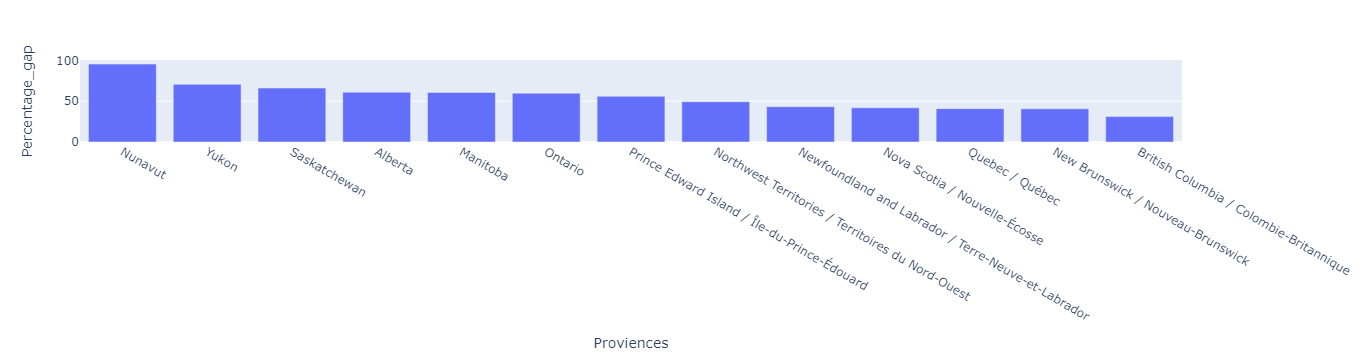

In [237]:
#Adding percentage column to find the gap and better understanding
result_find_gap["Percentage_gap"] = (result_find_gap["Crt_Size_Total"]/result_find_gap["Size_Total"])*100
result_find_gap.sort_values(by="Percentage_gap", ascending=False,inplace=True)
result_find_gap.head(13)

import plotly.express as px
fig = px.bar(result_find_gap, x='Proviences',y='Percentage_gap')
fig.show()